# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [32]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt

### Retrieve data, convert strings to `datetime`

In [2]:
data = pd.read_csv('./eshop.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
data

,Customer ID,Date,Subtotal,Country
0,34,2007-06-21,86.00,Czech Republic
1,38,2007-06-27,38.40,Czech Republic
2,47,2007-07-02,53.50,Slovakia
3,61,2007-07-14,7.00,Czech Republic
4,78,2007-07-21,55.50,Czech Republic
...,...,...,...,...
22403,15356,2015-12-18,31.87,Czech Republic
22404,15357,2015-12-18,6.10,Czech Republic
22405,15358,2015-12-18,153.23,Czech Republic
22406,15359,2015-12-19,19.15,Czech Republic


In [78]:
today = datetime.datetime(2015,12,19)

def RFM_standard(df):
    result = []
    for id, d in df.groupby(by='Customer ID'):
        result.append([
            id,
            (today - d['Date'].max()).days,
            len(d),
            d['Subtotal'].sum(),
        ])
    return pd.DataFrame(data=result, columns=['ID','R','F','M'])

def RFM_bonus(df):
    result = []
    for id, d in df.groupby(by='Customer ID'):
        result.append([
            id,
            max((today - d['Date'].max()).days / 30, 1),
            max(
                len (
                    # dataframe with all purchases of current client in last 365 days
                    d[d['Date'] > today - datetime.timedelta(days = 365)]
                )
                , 1),
            d['Subtotal'].max(),
        ])
    return pd.DataFrame(data=result, columns=['ID','R','F','M'])

### Evaluate **R**ecency, **F**requency and **M**onetary for data, and save in separate frame

In [110]:
print('standard approach to RFM')
rfm = RFM_standard(data)
display(rfm)
rfm.describe()

standard approach to RFM


,ID,R,F,M
0,7,311,3,15.54
1,9,3050,1,13.20
2,30,3025,1,36.20
3,34,3103,1,86.00
4,38,3097,1,38.40
...,...,...,...,...
12824,15356,1,1,31.87
12825,15357,1,1,6.10
12826,15358,1,1,153.23
12827,15359,0,1,19.15


,ID,R,F,M
count,12829.000000,12829.000000,12829.000000,12829.000000
mean,8144.681581,1102.619690,1.746668,155.806657
std,4259.227122,726.546225,2.010044,407.744435
min,7.000000,0.000000,1.000000,1.180000
25%,4465.000000,456.000000,1.000000,32.040000
50%,8203.000000,1062.000000,1.000000,64.810000
75%,11844.000000,1681.000000,2.000000,143.510000
max,15360.000000,3103.000000,45.000000,21392.380000


### Normalization

Since k-means works with geometrical distances in vectorspase - different scales of features(columns) might influence their result not in the best way, so I decided to normalize the data.

In [148]:
def norm_column(df, name):
    c_min = df[name].min()
    c_max = df[name].max()
    df[name] = (df[name] - c_min)/(c_max - c_min)
    
def normalize(df):
    df_copy = df.copy()
    norm_column(df_copy,'R')
    norm_column(df_copy,'F')
    norm_column(df_copy,'M')
    return df_copy

In [149]:
normalized = normalize(rfm)

In [150]:
display(normalized)

,ID,R,F,M
0,7,0.100226,0.045455,0.000671
1,9,0.982920,0.000000,0.000562
2,30,0.974863,0.000000,0.001637
3,34,1.000000,0.000000,0.003965
4,38,0.998066,0.000000,0.001740
...,...,...,...,...
12824,15356,0.000322,0.000000,0.001435
12825,15357,0.000322,0.000000,0.000230
12826,15358,0.000322,0.000000,0.007108
12827,15359,0.000000,0.000000,0.000840


### By elbow method determine k in k-means

In [129]:
def elbow_kmeans(dataset):
    m_iter = 300
    ids = []
    sum_of_distances = []
    for k in range(8):
        alg = KMeans(n_clusters=k+1, random_state=1, max_iter=m_iter)
        alg.fit(dataset.drop(columns='ID'))
        ids.append(k+1)
        sum_of_distances.append(alg.inertia_)
        if alg.n_iter_ > m_iter - 10:
            print('didn\'t converge with k=',k)
        
    plt.plot(ids, sum_of_distances)
    plt.xlabel('k')
    plt.ylabel('sum of squared distances from geometrical centre of closest cluster', rotation=90)

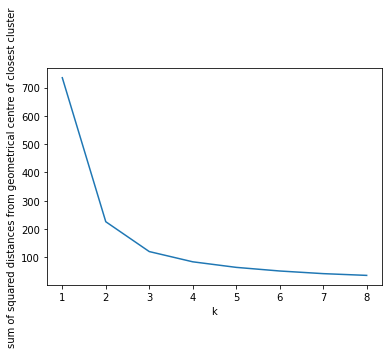

In [151]:
elbow_kmeans(normalized)

To me **k = 3** looks most appealing. After that inertia doesn't change that fast.

### Split data into clusters, and describe the outcome

In [152]:
def clusterize(df, k):
    alg = KMeans(n_clusters=k, random_state=1)
    alg.fit(df.drop(columns = 'ID'))
    df_copy = df.copy()
    df_copy['Cluster'] = alg.labels_
    
    for cluster_id, clients in df_copy.groupby(by='Cluster'):
        print('\n\nCluster',cluster_id)
        #display(clients)
        display(clients.describe())
        
    return df_copy

In [153]:
clusterized = clusterize(normalized,3)



Cluster 0


,ID,R,F,M,Cluster
count,4654.000000,4654.000000,4654.000000,4654.000000,4654.0
mean,12149.474216,0.106639,0.028915,0.010649,0.0
std,2934.286937,0.070607,0.064099,0.023647,0.0
min,7.000000,0.000000,0.000000,0.000000,0.0
25%,11534.250000,0.041573,0.000000,0.001712,0.0
50%,12817.000000,0.104415,0.000000,0.003791,0.0
75%,14121.750000,0.163632,0.022727,0.009497,0.0
max,15360.000000,0.256204,1.000000,0.418116,0.0




Cluster 1


,ID,R,F,M,Cluster
count,3484.000000,3484.000000,3484.000000,3484.000000,3484.0
mean,3092.211251,0.660210,0.006517,0.003940,1.0
std,1451.878854,0.102147,0.020690,0.005676,0.0
min,9.000000,0.518208,0.000000,0.000023,1.0
25%,1957.250000,0.578150,0.000000,0.001219,1.0
50%,3130.500000,0.635514,0.000000,0.002271,1.0
75%,4311.250000,0.724460,0.000000,0.004491,1.0
max,5608.000000,1.000000,0.613636,0.100664,1.0




Cluster 2


,ID,R,F,M,Cluster
count,4691.000000,4691.000000,4691.000000,4691.000000,4691.0
mean,7923.940098,0.375653,0.012883,0.006278,2.0
std,2141.062364,0.080128,0.032779,0.019863,0.0
min,53.000000,0.240735,0.000000,0.000022,2.0
25%,6568.500000,0.306478,0.000000,0.001463,2.0
50%,8067.000000,0.374476,0.000000,0.003008,2.0
75%,9609.500000,0.445053,0.022727,0.006548,2.0
max,11242.000000,0.520142,0.500000,1.000000,2.0


Now let's take a look at each cluster, and see how they are different.
* **Cluster 0**: Lowest mean recency, highest frequency and monetary among other clusters. Best clients.
* **Cluster 1**: Lowest Frequency and Monetary, highest Recency. Old, non regular customers. 
* **Cluster 2**: Recency and Frequency 2 times worse than in **Cluster 0**. Avarage customers.

I didn't really like how elbow method suggested `k` to split the data, I think there should be some more distinct variety in resulting clusters. I'll try to find a better `k` with [silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [154]:
from sklearn import metrics

In [176]:
ids = []
scores = []
tmp = normalized.drop(columns='ID')
for k in range(2,15):
    model = KMeans(n_clusters=k, random_state=1).fit(tmp)
    ids.append(k)
    scores.append(metrics.silhouette_score(tmp, model.labels_, metric='euclidean'))

Text(0, 0.5, 'Silhouette score')

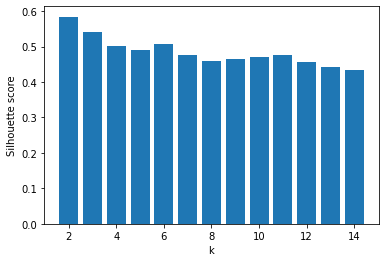

In [177]:
plt.bar(x = ids, height=scores)
plt.xlabel('k')
plt.ylabel('Silhouette score', rotation=90)

To me it looks strange, highest silhouette score with only 2 clusters. I expected it to be around 12 and distinguish customers with
* extremely high monetary and low frequency
* extreme monetary and high frequency
* avarage monetary
* extreme recency
* .
* .
* .

...
and so on. But really distinctive clusters

Probably I got this kind of behavior because I did sth. wrong in data normalization.